In [1]:
import os
import sys
import platform
import torch
sys.path.append('/Users/orberebi/Documents/GitHub/TUB-BGU-colab/PyTorch/')

import scipy.io
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(threshold=4)
import torch

import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm

import local_functions as f
import AK_ILD_pytorch as ak

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if torch.backends.mps.is_built() \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
device = "cpu"
print(f"Target device is {device}")



Python Platform: macOS-13.4.1-arm64-i386-64bit
PyTorch Version: 2.2.2

Python 3.10.14 (main, Mar 21 2024, 11:21:31) [Clang 14.0.6 ]
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is cpu


# Intro:
### In this notebook we load a .mat file with HRTF SH coefficients (and some other things) and optimize them to reduce the ILD error

| Variable           | dimensions                                                      | description |
| :----------------  | :------                                                         | :--- |
| p_f_high_lebedev   |  [$\Omega$ x positive frequencies x left/right]                 | Measured HRTF which represents the reference binaural signals from all directions |
| ILD_ref            |  [$f_c$ x $\Omega_{az}$ ]                                       | Reference ILD curve, based on the messured HRTF |
| f_band             |  [$f_{low}$ , $f_{high}$]                                       | The lower and upper frequency band for the ILD calculations |
| Hnm_low            |  [$(N_{low}+1)^2$ x positive frequencies x  left/right ]        | The SH least squeres coefficients |
| Hnm_mls            |  [$(N_{low}+1)^2$ x positive frequencies x  left/right ]        | The SH magnitude least squeres coefficients |
| Hnm_high           |  [$(N_{high}+1)^2$ x positive frequencies x  left/right ]       | The high order SH least squeres coefficients |
| fs                 |  scalar                                                         | sample rate |
| N_low              |  scalar                                                         | low order |
| N_high             |  scalar                                                         | high order for refference |
| f_vec              |  [$f$ x 1]                                                      | positive frequencies bins vector |
| ang_vec            |  [$\Omega_{az}$ x 1]                                            | Angles in degrees for ILD calculations |
| Y_high_lebedev     |  [$\Omega$ x $(N_{high}+1)^2$]                                  | SH matrix for high order over lebedev directions |
| Y_high_az          |  [$\Omega_{az}$ x $(N_{high}+1)^2$]                             | SH matrix for high order over azimuth directions |
| Y_low_lebedev      |  [$\Omega$ x $(N_{low}+1)^2$]                                   | SH matrix for low order over lebedev directions |
| Y_low_az           |  [$\Omega_{az}$ x $(N_{low}+1)^2$]                              | SH matrix for low order over azimuth directions |

In [2]:
# Load the MatLab data file
path_matlab_data = "/Users/orberebi/Documents/GitHub/TUB-BGU-colab/matlab_saved_data/KU100_HRIR_L2702_N1.mat"
mat = scipy.io.loadmat(path_matlab_data)



In [3]:
# Assign the local names for the variables (extract theme from the matlab dict)
fs = mat["fs"][0,0]
f_band  = mat["f_band"][0]
N_low = mat["N_low"][0]
N_high = mat["N_high"][0]
f_vec = mat["f_vec"]
ang_vec = mat["ang_vec"]

nfft = (f_vec.shape[0]-1)*2


Hnm_high       = mat["Hnm_high"]
Hnm_high       = torch.from_numpy(Hnm_high).to(device)
Hnm_low        = mat["Hnm_low"]
Hnm_low       = torch.from_numpy(Hnm_low).to(device)
Hnm_mls        = mat["Hnm_mls"]
Hnm_mls       = torch.from_numpy(Hnm_mls).to(device)

Y_high_lebedev = mat["Y_high_lebedev"]
Y_high_lebedev = torch.from_numpy(Y_high_lebedev).to(device)
Y_high_az      = mat["Y_high_az"]
Y_high_az      = torch.from_numpy(Y_high_az).to(device)
Y_low_lebedev  = mat["Y_low_lebedev"]
Y_low_lebedev  = torch.from_numpy(Y_low_lebedev).to(device)
Y_low_az       = mat["Y_low_az"]
Y_low_az       = torch.from_numpy(Y_low_az).to(device)


p_f_high_lebedev = mat["p_f_high_lebedev"]
p_f_high_lebedev = torch.from_numpy(p_f_high_lebedev).to(device)
ILD_ref          = mat["ILD_ref"]
ILD_ref          = torch.from_numpy(ILD_ref).to(device)



print("p_f_high_lebedev",p_f_high_lebedev.shape, "\t",p_f_high_lebedev.dtype)
print("ILD_ref \t",ILD_ref.shape, "\t\t",ILD_ref.dtype)
print("")
print("Hnm_high\t",Hnm_high.shape, "\t",Hnm_high.dtype)
print("Hnm_low\t\t",Hnm_low.shape, "\t",Hnm_low.dtype)
print("Hnm_mls\t\t",Hnm_mls.shape, "\t",Hnm_mls.dtype)
print("")
print("Y_high_lebedev\t",Y_high_lebedev.shape, "\t",Y_high_lebedev.dtype)
print("Y_high_az\t",Y_high_az.shape, "\t",Y_high_az.dtype)
print("Y_low_lebedev\t",Y_low_lebedev.shape, "\t\t",Y_low_lebedev.dtype)
print("Y_low_az\t",Y_low_az.shape, "\t\t",Y_low_az.dtype)
print("")



print("f_band\t\t",f_band.shape, "\t\t\t\t",f_band.dtype)
print("fs\t\t",fs.shape, "\t\t\t\t",fs.dtype)
print("f_vec\t\t",f_vec.shape, "\t\t\t",f_vec.dtype)
print("ang_vec\t\t",ang_vec.shape, "\t\t\t",ang_vec.dtype)
print("N_high\t\t",N_high.shape, "\t\t\t\t",N_high.dtype)
print("N_low\t\t",N_low.shape, "\t\t\t\t",N_low.dtype)




p_f_high_lebedev torch.Size([2702, 257, 2]) 	 torch.complex128
ILD_ref 	 torch.Size([22, 361]) 		 torch.float64

Hnm_high	 torch.Size([1849, 257, 2]) 	 torch.complex128
Hnm_low		 torch.Size([4, 257, 2]) 	 torch.complex128
Hnm_mls		 torch.Size([4, 257, 2]) 	 torch.complex128

Y_high_lebedev	 torch.Size([2702, 1849]) 	 torch.complex128
Y_high_az	 torch.Size([361, 1849]) 	 torch.complex128
Y_low_lebedev	 torch.Size([2702, 4]) 		 torch.complex128
Y_low_az	 torch.Size([361, 4]) 		 torch.complex128

f_band		 (2,) 				 uint16
fs		 () 				 uint16
f_vec		 (257, 1) 			 float64
ang_vec		 (361, 1) 			 float64
N_high		 (1,) 				 uint8
N_low		 (1,) 				 uint8


In [4]:
# Calculate the NMSE and magnitude error

# Calc the low-order HRTF in the Omega directions
p_ls_lbd = f.spatial_interpolation(Hnm_low,Y_low_lebedev)
p_mls_lbd = f.spatial_interpolation(Hnm_mls,Y_low_lebedev)

# Calc the NMSE and Magnitude error for each set of Hnm
e_ls_nmse = f.clc_e_nmse(p_f_high_lebedev,p_ls_lbd,True).numpy()
e_ls_mag = f.clc_e_mag(p_f_high_lebedev,p_ls_lbd,True).numpy()

e_mls_nmse = f.clc_e_nmse(p_f_high_lebedev,p_mls_lbd,True).numpy()
e_mls_mag = f.clc_e_mag(p_f_high_lebedev,p_mls_lbd,True).numpy()



In [5]:

# Calculate reference high-order p in time
p_high_az_t  = f.spatial_interpolation(Hnm_high,Y_high_az,True)
p_high_az_t  = torch.from_numpy(p_high_az_t).to(device)
# This is a One time operation for getting the constanct that are needed for the AK-ILD calculations
P = torch.permute(p_high_az_t, (0, 2, 1))
AK_Nmax,AK_f_c,AK_n,AK_C     = ak.AKerbILD_short_p1(P, f_band, fs)
AK_C  = torch.from_numpy(AK_C).to(device)

# Calculate low order p in time (to evaluate it's ILD)
p_ls_az_t  = f.spatial_interpolation(Hnm_low,Y_low_az,True)
p_ls_az_t  = torch.from_numpy(p_ls_az_t).to(device)
p_mls_az_t  = f.spatial_interpolation(Hnm_mls,Y_low_az,True)
p_mls_az_t  = torch.from_numpy(p_mls_az_t).to(device)

# Calculate the ILD error for each low-order representation
e_ILD_ls = ak.clc_e_ILD(p_ls_az_t, AK_f_c, fs, f_band, AK_Nmax, AK_n, AK_C, nfft,ILD_ref)
e_ILD_mls = ak.clc_e_ILD(p_mls_az_t, AK_f_c, fs, f_band, AK_Nmax, AK_n, AK_C, nfft,ILD_ref)


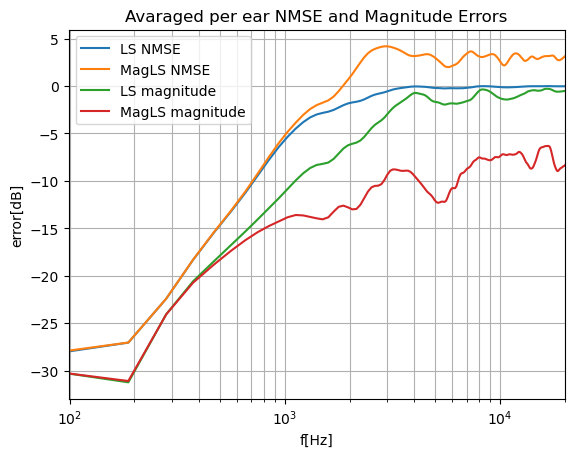

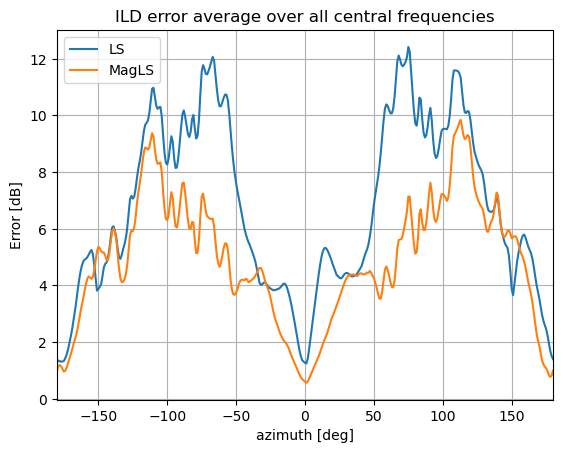

In [6]:
# Prints some graphs


plt.plot(f_vec,e_ls_nmse)
plt.plot(f_vec,e_mls_nmse)
plt.plot(f_vec,e_ls_mag)
plt.plot(f_vec,e_mls_mag)
plt.xlim([99,20e3])
plt.xscale('log')
plt.xlabel("f[Hz]")
plt.grid(which='both')
plt.title("Avaraged per ear NMSE and Magnitude Errors")
plt.legend(["LS NMSE","MagLS NMSE","LS magnitude","MagLS magnitude"])
plt.ylabel("error[dB]");
plt.show()



plt.plot(ang_vec,e_ILD_ls)
plt.plot(ang_vec,e_ILD_mls)
plt.grid()
plt.xlabel("azimuth [deg]")
plt.ylabel("Error [dB]")
plt.legend(["LS","MagLS"])
plt.xlim((ang_vec[0], ang_vec[-1]))
plt.title("ILD error average over all central frequencies");
plt.show()


# Now I need to implement the pythorch optimiztion via the NN